In [40]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [41]:
def encoders(f):
    words = f.read().splitlines()
    names = ''.join(words)
    vocab = sorted(list(set(names)))
    vocab = ['.'] + vocab
    vocab_size = len(vocab)
    stoi = {c: i for i, c in enumerate(vocab)}
    itos = {c: i for i, c in stoi.items()}

    return vocab, vocab_size, stoi, itos, words

def process(words,stoi):
    X = []
    Y = []
    block_size = 3
    for w in words:
        context = [0]*block_size
        for c in w+ '.':
            X.append(context)
            Y.append(stoi[c])
            context = context[1:] + [stoi[c]]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    return X,Y

def data():
    with open('names.txt', 'r') as f:
        vocab, vocab_size, stoi, itos, words = encoders(f)
        n1 = int(len(words)*0.8)
        n2 = int(len(words)*0.9)
        xtrain, ytrain = process(words[:n1],stoi)
        xtest, ytest = process(words[n1:n2],stoi)
        xval, yval = process(words[n2:],stoi)

        print(f"xtrain and ytrain shape: {xtrain.shape}, {ytrain.shape}")
        print(f"xtest and ytest shape: {xtest.shape}, {ytest.shape}")
        print(f"xval and yval shape: {xval.shape}, {yval.shape}")
        return xtrain, ytrain, xtest, ytest, xval, yval, vocab_size, stoi, itos

In [42]:
xtrain, ytrain, xtest, ytest, xval, yval, vocab_size, stoi, itos = data()

xtrain and ytrain shape: torch.Size([182778, 3]), torch.Size([182778])
xtest and ytest shape: torch.Size([22633, 3]), torch.Size([22633])
xval and yval shape: torch.Size([22735, 3]), torch.Size([22735])


In [56]:
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.W = torch.randn(fan_in, fan_out ) / fan_in**0.5
        self.b = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.W
        if self.b != None:
            return self.out + self.b
        else:
            return self.out
    
    def parameters(self):
        return [self.W] + ([] if self.b == None else [self.b])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1, training=True):
        self.eps = eps
        self.momentum = momentum
        self.training = training
        # params
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    def __call__(self,x):
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, unbiased=True, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt((xvar + self.eps))
        self.out = xhat * self.gamma + self.beta

        # update buffers
        if self.training:
            self.running_mean = self.momentum * xmean + (1 - self.momentum) * self.running_mean
            self.running_var = self.momentum * xvar + (1 - self.momentum) * self.running_var
        
        return self.out
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    
n_emb = 10
n_hidden = 100

C = torch.randn(vocab_size, n_emb)
layers = [Linear(n_emb*3, n_hidden), BatchNorm1d(n_hidden), Tanh(),
          Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
          Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
          Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
          Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
          Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size),
          ]

with torch.no_grad():
    layers[-1].gamma *= 0.1

    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.W *= 5/3

parameters = [param for layer in layers for param in layer.parameters()]
print(f"Number of parameters: {sum(param.nelement() for param in parameters)}")
for p in parameters:
    p.requires_grad = True

Number of parameters: 47281


In [57]:
max_steps = 80000
batch_size = 32
lossi = []
stepi = []
ud = []
for i in range(max_steps):
    ix = torch.randint(0, xtrain.shape[0], (batch_size,))
    xb, yb = xtrain[ix], ytrain[ix]

    emb = C[xb]
    x = emb.view(-1, xtrain.shape[1]*n_emb) # n, n_emb*block_size

    for layer in layers:
        x = layer(x)
    
    loss = F.cross_entropy(x, yb)
    
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad.std())/p.data.std()).log10().item() for p in parameters])

    lr = 0.1 if i < max_steps/2 else 0.01
    with torch.no_grad():
        for p in parameters:
            p -= lr * p.grad
    if i % (max_steps//10) == 0:
        print(f"Step {i}, Loss {loss.item()}")
    if i>=1500:
        break

Step 0, Loss 3.3255863189697266


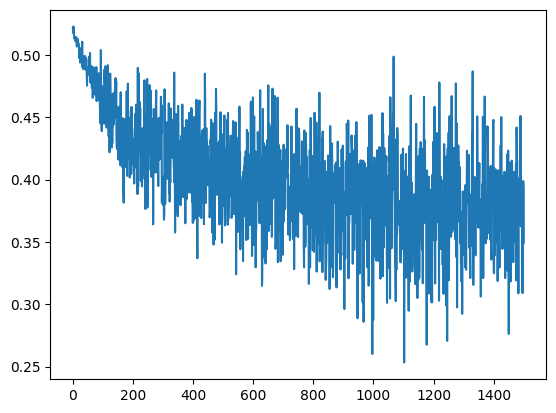

In [58]:
plt.plot(lossi)

layer 2(Tanh): mean 4.613295095623471e-05, std 0.6311365962028503, saturated 2.8125%
layer 5(Tanh): mean -0.002560180611908436, std 0.6427580118179321, saturated 2.53125%
layer 8(Tanh): mean 0.0022106876131147146, std 0.6403576731681824, saturated 2.21875%
layer 11(Tanh): mean 0.0007461801287718117, std 0.6454868912696838, saturated 2.1875%
layer 14(Tanh): mean -0.004195014946162701, std 0.6414832472801208, saturated 2.0%


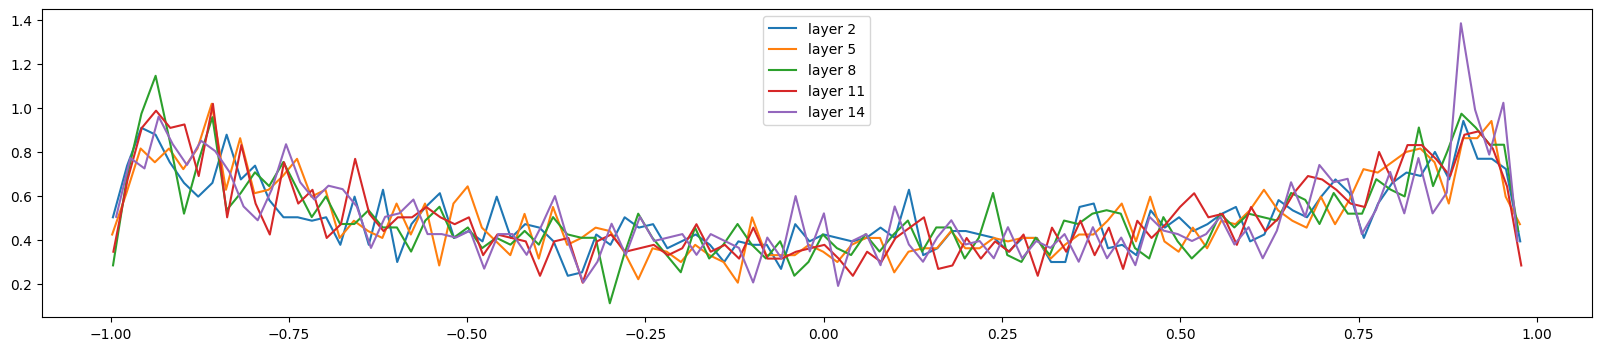

In [59]:
plt.figure(figsize=(20,4))
legends = []
for i,l in enumerate(layers[:-1]):
    if isinstance(l, Tanh):
        t = l.out
        print(f'layer {i}(Tanh): mean {t.mean()}, std {t.std()}, saturated {(t.abs()>0.97).float().mean()*100}%')
        counts, bins = torch.histogram(t, density=True)
        plt.plot(bins[:-1].detach(), counts.detach())
        legends.append(f'layer {i}')
plt.legend(legends)

layer 0(Linear): mean 1.4551915445207286e-12, std 0.00208485615439713
layer 3(Linear): mean 6.984919153490976e-12, std 0.0022740939166396856
layer 6(Linear): mean 2.619344845189442e-12, std 0.0019606659188866615
layer 9(Linear): mean 2.9103830890414573e-12, std 0.0017629361245781183
layer 12(Linear): mean -4.656612768993984e-12, std 0.0016637420048937201
layer 15(Linear): mean 0.0, std 0.0030123868491500616


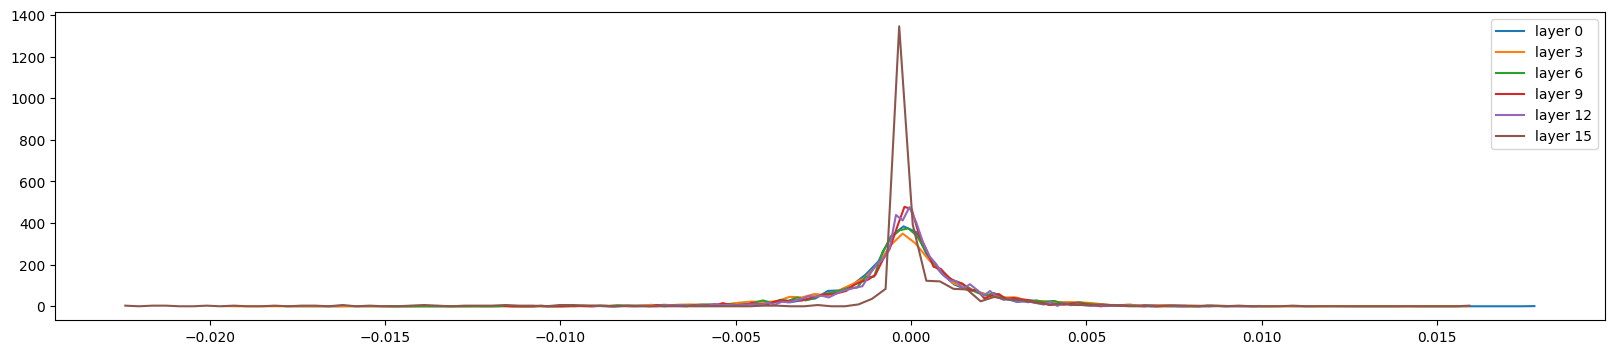

In [60]:
plt.figure(figsize=(20,4))
legends = []
for i,l in enumerate(layers[:-1]):
    if isinstance(l, Linear):
        t = l.out.grad
        print(f'layer {i}(Linear): mean {t.mean()}, std {t.std()}')
        counts, bins = torch.histogram(t, density=True)
        plt.plot(bins[:-1].detach(), counts.detach())
        legends.append(f'layer {i}')

plt.legend(legends)

param 0: mean -8.256200089817867e-05| std 0.010780936107039452 | grad:data ratio 0.03603321313858032
param 4: mean -6.98757212376222e-05| std 0.008073845878243446 | grad:data ratio 0.04778385907411575
param 8: mean -2.646615575940814e-05| std 0.007053976412862539 | grad:data ratio 0.04192420467734337
param 12: mean -2.4965451302705333e-05| std 0.00652856333181262 | grad:data ratio 0.0391995832324028
param 16: mean 2.5381486921105534e-05| std 0.005929368082433939 | grad:data ratio 0.03562477231025696
param 20: mean 0.00011762572830775753| std 0.010108108632266521 | grad:data ratio 0.05850057303905487


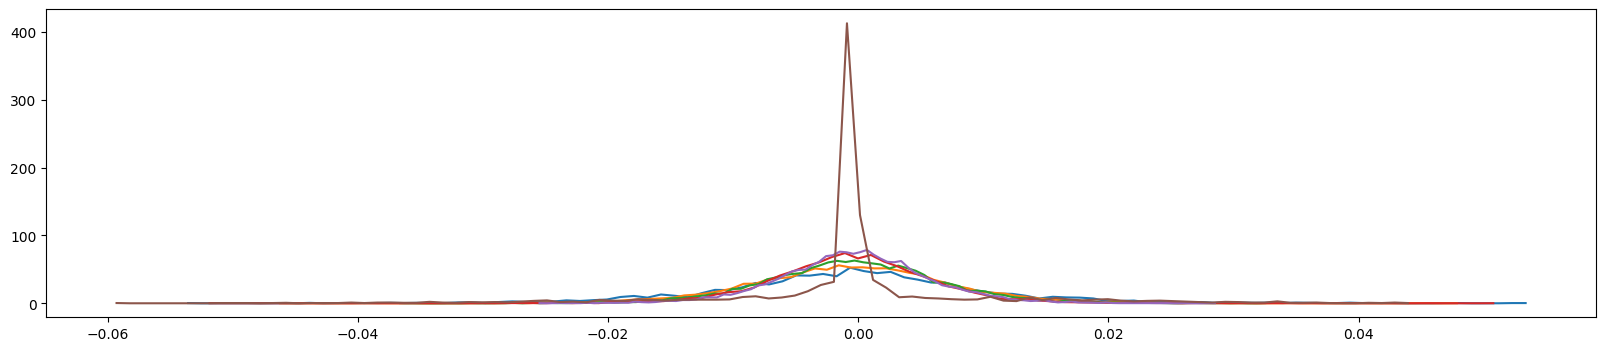

In [61]:
plt.figure(figsize=(20,4))
legends = []
for i,l in enumerate(parameters):
    if l.ndim == 2:
        t = l.grad
        print(f'param {i}: mean {t.mean()}| std {t.std()} | grad:data ratio {t.std()/l.std()}')
        counts, bins = torch.histogram(t, density=True)
        plt.plot(bins[:-1].detach(), counts.detach())
        legends.append(f'param {i}')

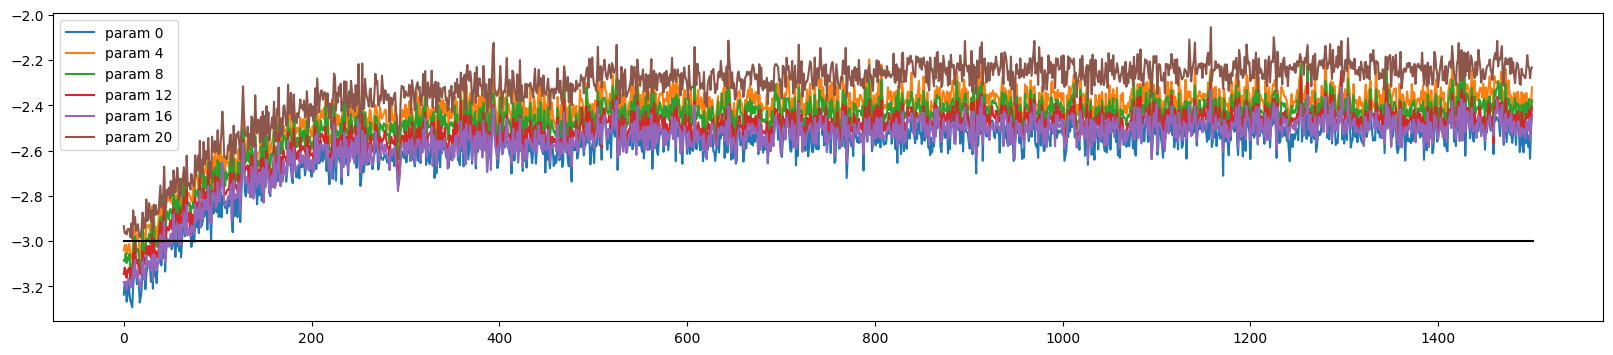

In [62]:
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'param {i}')

plt.plot([0,len(ud)],[-3,-3],'k') 
plt.legend(legends)